# Libraries

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from skimage.metrics import structural_similarity as ssim

# Downloading Images

In [4]:
!gdown 1r5y4rduepVcbb4WnNaD6LuZfzSEADd_l -O original.jpg
!gdown 1iKfaxZG0CtM_4smItfrFax-YVVAPgdrM -O watermark.jpg

Downloading...
From: https://drive.google.com/uc?id=1r5y4rduepVcbb4WnNaD6LuZfzSEADd_l
To: /content/original.jpg
100% 3.26M/3.26M [00:00<00:00, 262MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iKfaxZG0CtM_4smItfrFax-YVVAPgdrM
To: /content/watermark.jpg
100% 823k/823k [00:00<00:00, 95.6MB/s]


# Displaying two images side by side for comparison

In [5]:
def show_images(images, titles=None, cmap='gray', figsize=(15, 10)):
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap=cmap)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Converting Grayscale Watermark into Binary Watermark
> It converts a grayscale watermark image into a binary mask with pixels either 0 or 1. Pixels above 127 become 1, and pixels 127 or below become 0.

In [6]:
def binarize_watermark(wm_gray):
    _, binary = cv2.threshold(wm_gray, 127, 1, cv2.THRESH_BINARY)
    return binary.astype(np.uint8)

# Image Padding
>  It pads an image so that its height and width become multiples of $2^n$.


In [7]:
def pad_to_multiple_of_2n(image, n):
    multiple = 2 ** n
    h, w = image.shape
    new_h = ((h + multiple - 1) // multiple) * multiple
    new_w = ((w + multiple - 1) // multiple) * multiple
    padded = np.zeros((new_h, new_w), dtype=image.dtype)
    padded[:h, :w] = image
    return padded

# Embed Watermark
>Embed a binary watermark (wm_bin) into a grayscale cover image (cover_gray) by modifying the DCT coefficients of the HL sub-band at a specific wavelet decomposition level.



1.   Wavelet Decomposition: Decompose the grayscale cover image into multiple wavelet sub-bands using Haar wavelets.
2.   Extract approximation and detail coefficients at the highest level
3.   Calculate the number of 8x8 blocks in HL
4.   Embed watermark bits in the DCT domain of each 8x8 block
5.   Reconstruct the modified coefficients list




In [8]:
def embed_watermark(cover_gray, wm_bin, level=3, alpha=5 ):

    coeffs = pywt.wavedec2(cover_gray, 'haar', level=level)
    cA = coeffs[0]
    cH, cV, cD = coeffs[1]

    coefficients = coeffs
    HL = cH.copy().astype(np.float32)

    Hh, Hw = HL.shape

    n_blocks_vert = Hh // 8
    n_blocks_horz = Hw // 8

    if wm_bin.shape != (n_blocks_vert, n_blocks_horz):
        raise ValueError(f"Watermark bit‐map must be exactly {n_blocks_vert}×{n_blocks_horz} for level={level} HL embedding.")

    for by in range(n_blocks_vert):
        for bx in range(n_blocks_horz):
            y0 = by * 8
            x0 = bx * 8
            block = HL[y0 : y0 + 8, x0 : x0 + 8].copy()
            dct_block = cv2.dct(block)

            if wm_bin[by, bx] == 1:
                dct_block[3, 3] = +alpha
            else:
                dct_block[3, 3] = -alpha

            HL[y0 : y0 + 8, x0 : x0 + 8] = cv2.idct(dct_block)

    coeffs_mod = [cA, (HL, cV, cD)] + coeffs[2:]

    rec = pywt.waverec2(coeffs_mod, 'haar')
    rec_clipped = np.clip(rec, 0, 255).astype(np.uint8)
    return rec_clipped


# Visualize Subbands

This function performs a multi-level 2D wavelet decomposition on an image, then reconstructs and visualizes the approximation and detail subbands (horizontal, vertical, diagonal) at each level. It shows how the image is broken down into different frequency components across scales, displaying them side-by-side for easy comparison.

In [9]:
def visualize_all_subbands(padded_img, wavelet='haar'):
    level = 3
    coeffs = pywt.wavedec2(padded_img, wavelet=wavelet, level=level)
    total_levels = len(coeffs) - 1
    fig, axes = plt.subplots(total_levels, 4, figsize=(16, 4 * total_levels))

    if total_levels == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(total_levels):
        level = total_levels - i

        new_coeffs = [coeffs[0] if j == 0 else (None, None, None) for j in range(len(coeffs))]
        for j in range(1, level):
            new_coeffs[j] = coeffs[j]

        approx_img = pywt.waverec2(new_coeffs, wavelet)

        approx_shape = coeffs[0].shape
        for _ in range(1, level):
            approx_shape = tuple(s * 2 for s in approx_shape)

        cH, cV, cD = coeffs[level]

        axes[i, 0].imshow(approx_img, cmap='gray')
        axes[i, 0].set_title(f'Level {level} Approximation\nSize: {approx_shape}')

        axes[i, 1].imshow(cH, cmap='gray')
        axes[i, 1].set_title(f'Level {level} Horizontal (cH)\nSize: {cH.shape}')

        axes[i, 2].imshow(cV, cmap='gray')
        axes[i, 2].set_title(f'Level {level} Vertical (cV)\nSize: {cV.shape}')

        axes[i, 3].imshow(cD, cmap='gray')
        axes[i, 3].set_title(f'Level {level} Diagonal (cD)\nSize: {cD.shape}')

        for ax in axes[i]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Convert images into Grayscale

In [10]:
orig_cover = cv2.imread('original.jpg', cv2.IMREAD_GRAYSCALE)
wm_gray   = cv2.imread('watermark.jpg', cv2.IMREAD_GRAYSCALE)

# Show Cover and Watermark

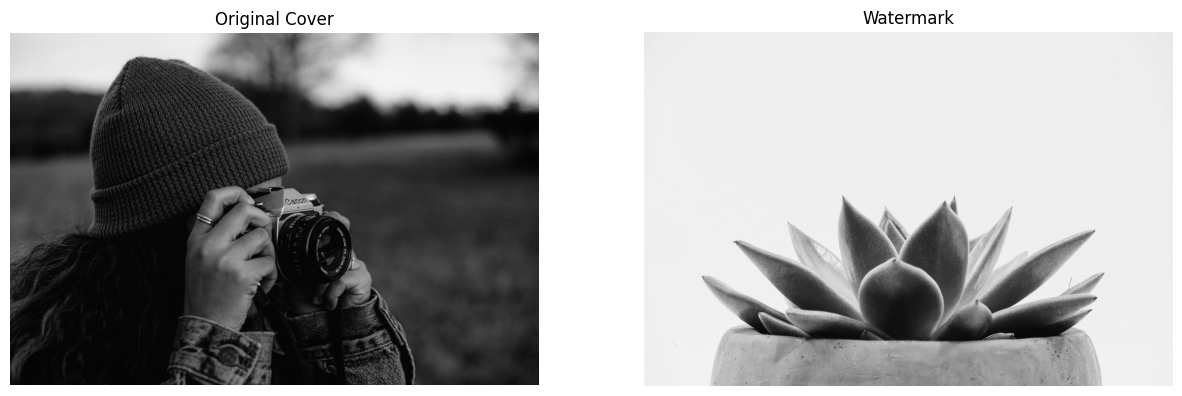

Size of original image (4000, 6000)
Size of watermark (4000, 5968)


In [11]:
show_images([orig_cover, wm_gray], ['Original Cover', 'Watermark'])
print("Size of original image", orig_cover.shape)
print("Size of watermark", wm_gray.shape)

# Pad Cover Image
> level chosen as 3

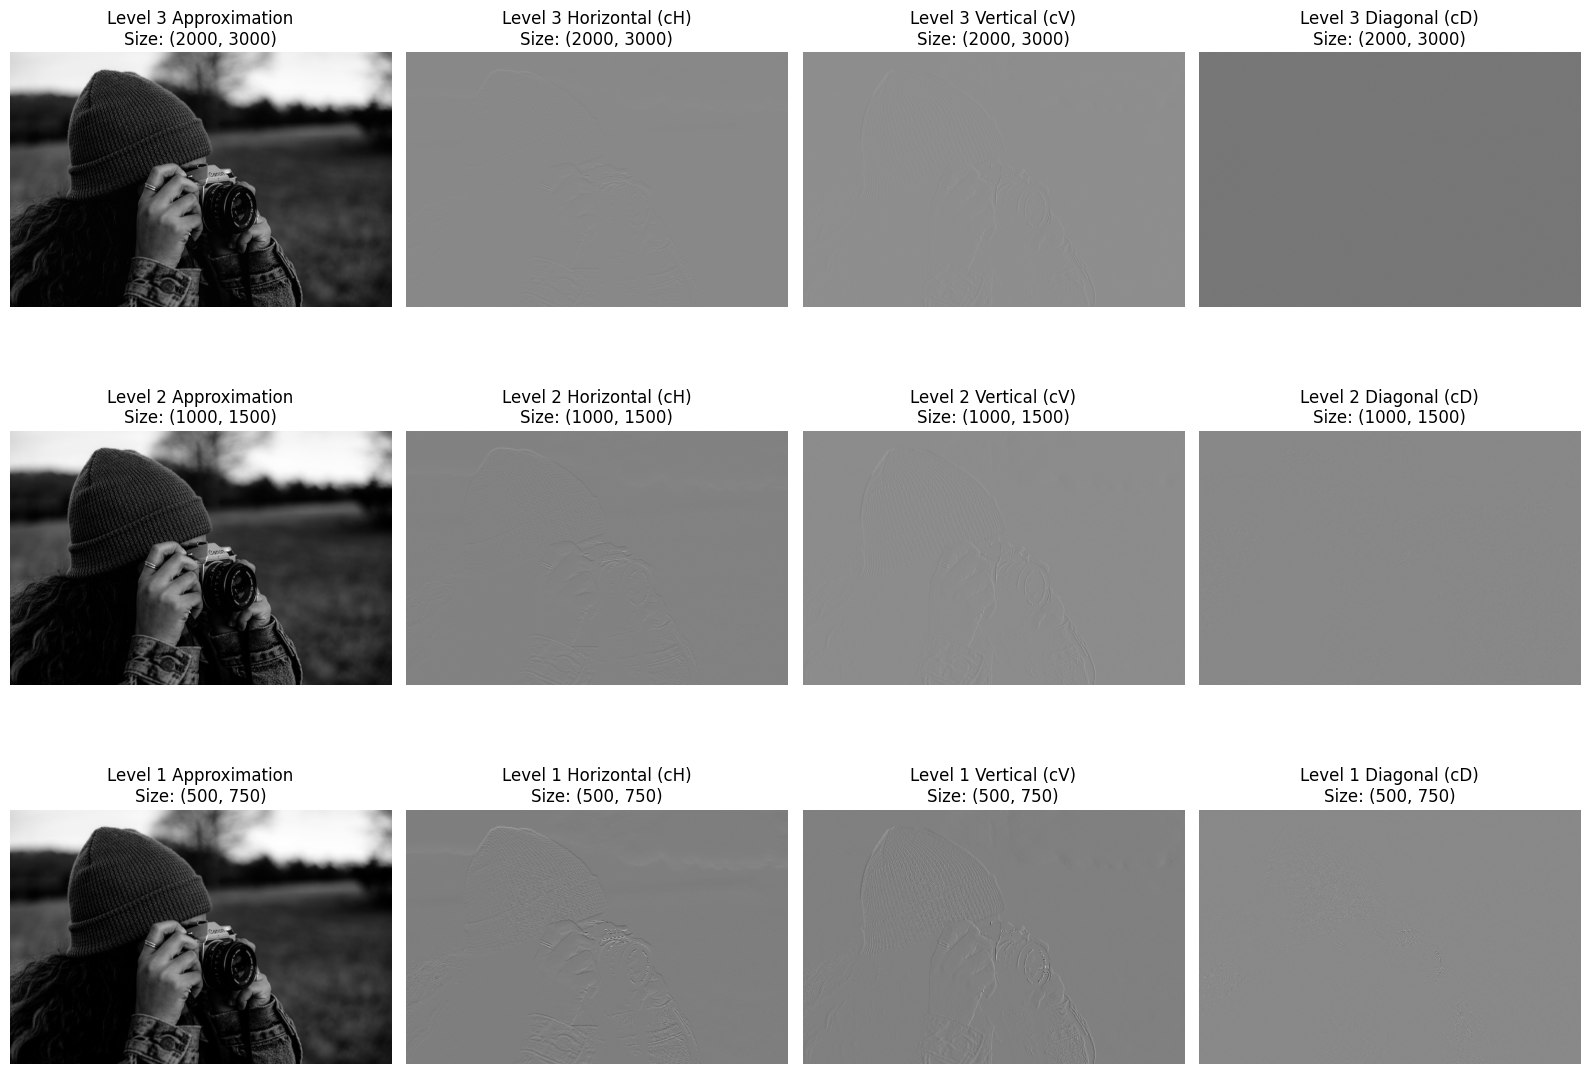

In [12]:
level = 3
padded_img = pad_to_multiple_of_2n(orig_cover, level)
visualize_all_subbands(orig_cover, wavelet='haar')

# Pre Processing

> Convert Datatype

In [13]:
cover_f = orig_cover.astype(np.float32)

> Choose Level and Pad

In [14]:
level = 3
padded_cover = pad_to_multiple_of_2n(cover_f, level)
H_pad, W_pad = padded_cover.shape

> Detect number of blocks

In [15]:
HL_h, HL_w = H_pad // 8, W_pad // 8
blocks_vertical = HL_h // 8
blocks_horizontal = HL_w // 8

> Resize and binarize watermark

In [16]:
wm_resized = cv2.resize(wm_gray,(blocks_horizontal, blocks_vertical),interpolation=cv2.INTER_AREA)
wm_bin = binarize_watermark(wm_resized)

# Show Binarized Watermark

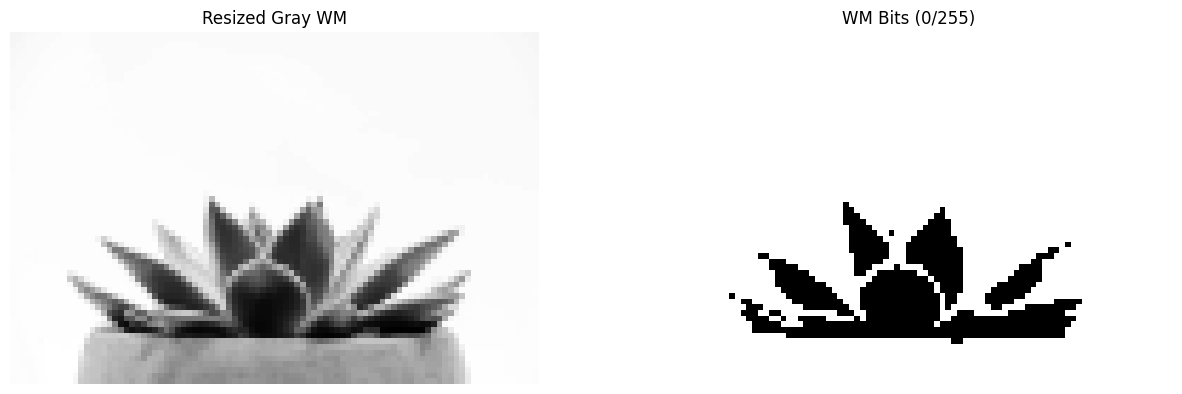

In [17]:
show_images([wm_resized, wm_bin * 255], titles=['Resized Gray WM', 'WM Bits (0/255)'])

# Watermark Image

In [18]:
alpha = 100
watermarked = embed_watermark(padded_cover, wm_bin, level=level, alpha=alpha)

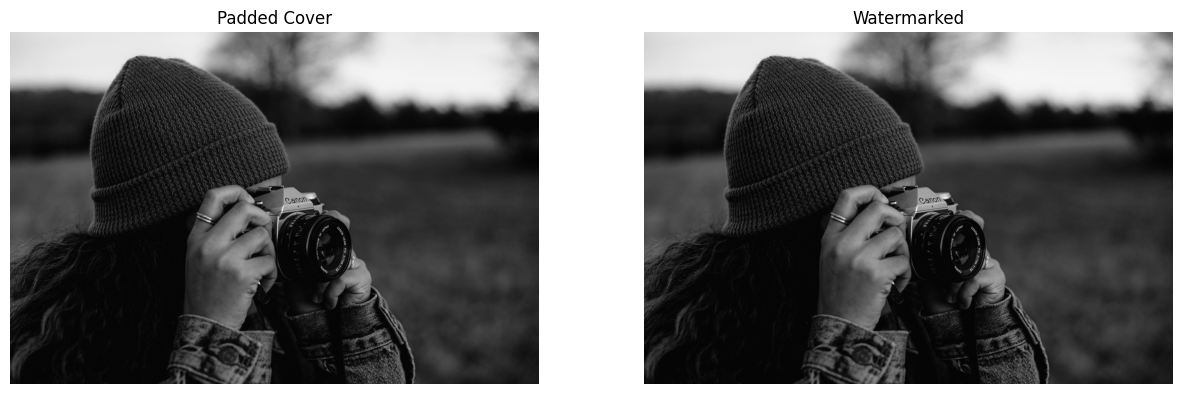

In [19]:
show_images([padded_cover.astype(np.uint8), watermarked], titles=['Padded Cover', 'Watermarked'])

# Comparing Original(padded) and watermarked image

In [20]:
def compare_images(original, watermarked):
    original_f = original.astype(np.float32)
    watermarked_f = watermarked.astype(np.float32)

    # MSE
    mse_val = np.mean((original_f - watermarked_f) ** 2)

    # PSNR
    psnr_val = cv2.PSNR(original.astype(np.uint8), watermarked.astype(np.uint8))

    # SSIM
    ssim_val = ssim(original, watermarked, data_range=original.max() - original.min())

    print(f"MSE: {mse_val:.4f}")
    print(f"PSNR: {psnr_val:.2f} dB")
    print(f"SSIM: {ssim_val:.4f}")

    return

In [21]:
compare_images(padded_cover, watermarked)

MSE: 2.8147
PSNR: 43.64 dB
SSIM: 0.9730


# Extract Watermark

In [22]:
def extract_watermark_from_HL(watermarked_gray, original_shape, level=3, alpha=5):

    coeffs_wm = pywt.wavedec2(watermarked_gray.astype(np.float32), 'haar', level=level)
    cA_wm = coeffs_wm[0]
    cH_wm, cV_wm, cD_wm = coeffs_wm[1]

    HL_wm = cH_wm.copy().astype(np.float32)

    Hh, Hw = HL_wm.shape
    n_blocks_vert = Hh // 8
    n_blocks_horz = Hw // 8

    recovered = np.zeros((n_blocks_vert, n_blocks_horz), dtype=np.uint8)

    for by in range(n_blocks_vert):
        for bx in range(n_blocks_horz):
            y0 = by * 8
            x0 = bx * 8
            block = HL_wm[y0 : y0 + 8, x0 : x0 + 8]
            dct_block = cv2.dct(block)

            recovered_bit = 1 if dct_block[3, 3] >= 0 else 0
            recovered[by, bx] = recovered_bit

    recovered_img = (recovered * 255).astype(np.uint8)
    return recovered_img

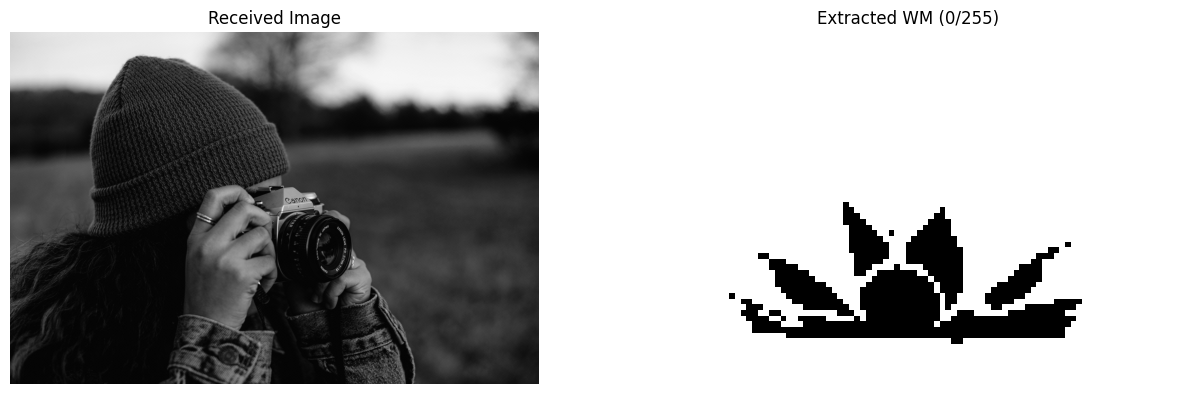

In [23]:
recovered = extract_watermark_from_HL(watermarked, padded_cover.shape, level=level, alpha=alpha)
show_images([watermarked, recovered], titles=['Received Image','Extracted WM (0/255)'])